In [69]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
from graphviz import Digraph

In [70]:
class Value:
    def __init__(self, data, _children=(), _operation="", label=""):
        self.data = data
        self.grad = 0.0
        # function to perform chain rule
        self._backward = lambda: None
        # set for efficiency
        self._prev = set(_children)
        self._operation = _operation
        self.label = label

    def __add__(self, other):
        # a = Value(1), to call a + 2 we need to convert 2 to Value
        other = other if isinstance(other, Value) else Value(other)
        output =  Value(self.data + other.data, (self, other), "+")

        # chain rule for addition
        # local derivative (in this case 1) * output gradient, we just propagate the gradient
        def _backward():
            self.grad += 1.0 * output.grad
            other.grad += 1.0 * output.grad

        output._backward = _backward

        return output
    
    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __mul__(self, other):
        # a = Value(1), to call a * 2 we need to convert 2 to Value
        # but 2 * a will not work, so we need to implement __rmul__
        other = other if isinstance(other, Value) else Value(other)
        output = Value(self.data * other.data, (self, other), "*")

        # chain rule for multiplication
        def _backward():
            self.grad += other.data * output.grad
            other.grad += self.data * output.grad
        
        output._backward = _backward

        return output

    # it is like fallback for __mul__
    # 2 * a will call a.__rmul__(2)
    def __rmul__(self, other):
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Power must be a number"
        output = Value(self.data ** other, (self,), f"**{other}")

        def _backward():
            self.grad += other * self.data**(other - 1) * output.grad
        
        output._backward = _backward

        return output

    def __truediv__(self, other):
        return self * (other ** -1)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        output = Value(t, (self,), "tanh")

        # chain rule for tanh
        # local derivative (in this case 1 - t**2) * output gradient
        def _backward():
            self.grad += (1 - t**2) * output.grad
        
        output._backward = _backward

        return output

    def exp(self):
        x = self.data 
        output = Value(math.exp(x), (self,), "exp")

        def _backward():
            self.grad += output.data * output.grad
        
        output._backward = _backward

        return output
    
    def backward(self):
        # we need to go backwards through the mm expression
        # we can achive this with topological sort on directed acyclic graph
        topo_graph = []
        visited = set()

        def build_topo_graph(node):
            if node not in visited:
                visited.add(node)
                
                for child in node._prev:
                    build_topo_graph(child)
                topo_graph.append(node)
                
        build_topo_graph(self)

        self.grad = 1.0

        # we can now go backwards through all nodes of the graph and compute the gradients
        for node in reversed(topo_graph):
            node._backward()
    
    def __repr__(self):
        return f"Value(data={self.data})"

In [71]:
def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)

            for child in v._prev:
                edges.add((child, v))
                build(child)
    
    build(root)
    return nodes, edges

def draw_graph(root):
    dot = Digraph(format="png", graph_attr={"rankdir": "LR"})

    nodes, edges = trace(root)

    for node in nodes:
        uid = str(id(node))

        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (node.label, node.data, node.grad), shape="record")

        if node._operation:
            dot.node(name=uid + node._operation, label=node._operation)
            dot.edge(uid + node._operation, uid)
        
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._operation)

    return dot


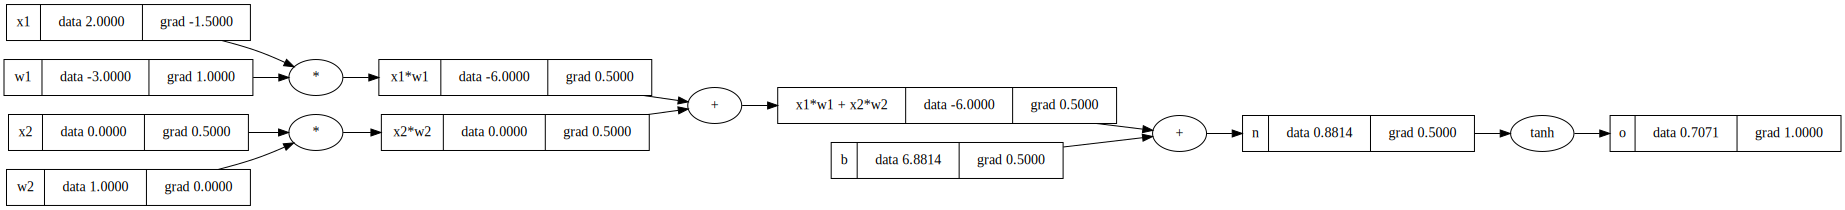

In [72]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'
o.backward()
draw_graph(o)

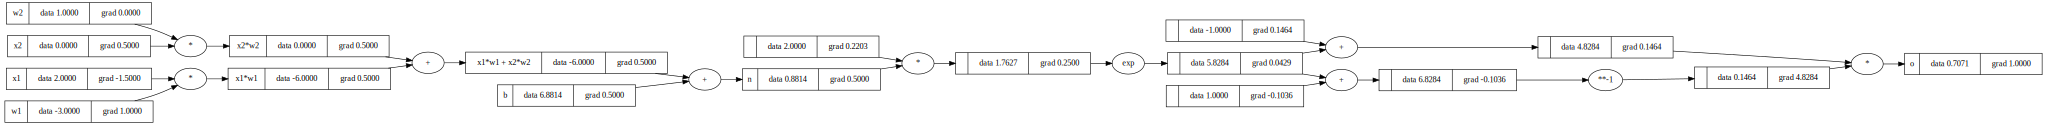

In [18]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp()
o = (e - 1) / (e + 1)
o.label = 'o'

o.backward()
draw_graph(o)

# PyTorch implementation

##### In PyTorch everything is based on tensors.  
##### Tensors are similar to numpy arrays, but they can also be used on a GPU to accelerate computing.

In [226]:
import torch

In [227]:
x1 = torch.tensor([2.0]).double()
x1.requires_grad = True
x2 = torch.tensor([0.0]).double()
x2.requires_grad = True
w1 = torch.tensor([-3.0]).double()
w1.requires_grad = True
w2 = torch.tensor([1.0]).double()
w2.requires_grad = True
b = torch.tensor([6.8813735870195432]).double()
b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.item())
o.backward()

print("Gradient of tensor object o with respect to x1, w1, x2, w2:")
print("x1 =", x1.grad.item())
print("w1 =", w1.grad.item())
print("x2 =", x2.grad.item())
print("w2 =", w2.grad.item())

0.7071066904050358
Gradient of tensor object o with respect to x1, w1, x2, w2:
x1 = -1.5000003851533106
w1 = 1.0000002567688737
x2 = 0.5000001283844369
w2 = 0.0


In [228]:
class Neuron:
    def __init__(self, n_inputs):
        self.weights = [Value(random.uniform(-1, 1)) for _ in range(n_inputs)]
        self.bias = Value(random.uniform(-1, 1))
    
    def __call__(self, x):
        # sum of all inputs multiplied by their weights + bias
        # sum second argument is the start value
        activation = sum((wi * xi for wi, xi in zip(self.weights, x)), self.bias)
        output = activation.tanh()

        return output

    # parameters of the neuron
    def parameters(self):
        return self.weights + [self.bias]

class Layer:
    # n_inputs is the number of inputs to the neuron
    # n_outputs is the number of neurons in the layer
    def __init__(self, n_inputs, n_outputs):
        self.neurons = [Neuron(n_inputs) for _ in range(n_outputs)]
    
    def __call__(self, x):
        outputs = [neuron(x) for neuron in self.neurons]
        return outputs[0] if len(outputs) == 1 else outputs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MultiLayerPerceptron:
    # n_inputs is the number of inputs to the neuron
    # n_outputs is the list of number of neurons in each layer
    def __init__(self, n_inputs, n_outputs):
        size = [n_inputs] + n_outputs
        self.layers = [Layer(size[i], size[i+1]) for i in range(len(n_outputs))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


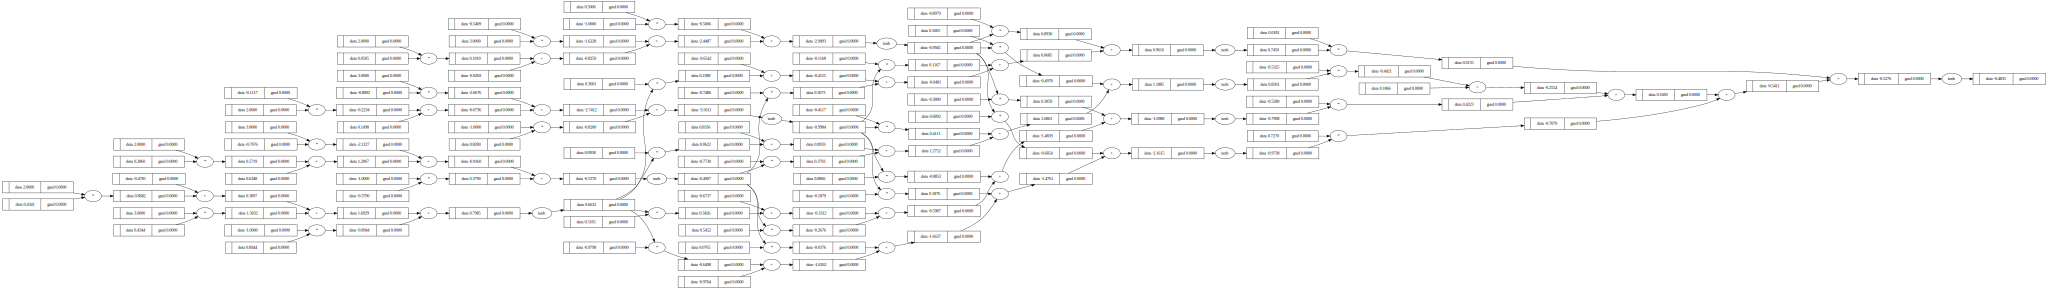

In [277]:
# Neural network
x = [2.0, 3.0, -1.0]
n = MultiLayerPerceptron(3, [4, 4, 1])
n(x)
draw_graph(n(x))

In [266]:
print("Number of parameters in the network:", len(n.parameters()))

Number of parameters in the network: 41


In [278]:
# input
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

# expected output
ys = [1.0, -1.0, -1.0, 1.0]

### Gradient descent optimization
In gradient descent, we think about gradient as a vector that points in the direction of the increase of the loss function.  
we want to change parameters values according to the gradient, by small step size in the direction of the gradient  
If learning rate (step) is too small it will take a long time to converge  
If learning rate is too large it will overshoot the minimum and diverge (explode)  

In [284]:
step = 0.05

for k in range(15):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum(((ypred - ygt)**2 for ygt, ypred in zip(ys, ypred)), Value(0.0))

    # backward pass
    # zero gradients
    for param in n.parameters():
        param.grad = 0.0

    loss.backward()

    # gradient descent - update parameters
    for param in n.parameters():
        param.data += -step * param.grad
    
    print(k, loss.data)

0 0.015512412598619494
1 0.01510924576351216
2 0.014725530201858905
3 0.014359919904627632
4 0.01401118882828733
5 0.013678217920188918
6 0.013359983783374177
7 0.013055548745065596
8 0.012764052130934863
9 0.012484702578407532
10 0.012216771248024916
11 0.01195958581326187
12 0.0117125251270095
13 0.011475014477818644
14 0.011246521361487608


In [285]:
print("Targets:")
print(ys)

# After several iterations
print("Predictions:")
print([y.data for y in ypred])

Targets:
[1.0, -1.0, -1.0, 1.0]
Predictions:
[0.9473596916529626, -0.955865841062815, -0.9313251175182229, 0.9574387990108616]


In [286]:
# set of parameters (weights and biases) that make the small loss
n.parameters()

[Value(data=0.2568038943399464),
 Value(data=0.056624998008291925),
 Value(data=1.197537078051768),
 Value(data=-0.5550927522266814),
 Value(data=0.4084703479261574),
 Value(data=-0.5132077032849675),
 Value(data=-0.35983693147040763),
 Value(data=0.7719659256895528),
 Value(data=0.008366679323130687),
 Value(data=-0.6942619207152647),
 Value(data=1.050048283375806),
 Value(data=0.3624640251517458),
 Value(data=0.1001921023846248),
 Value(data=-0.5520584147368962),
 Value(data=0.5113638696404178),
 Value(data=-0.9063130705795717),
 Value(data=0.3009618084794544),
 Value(data=-0.7742983968287583),
 Value(data=-0.08517941411392488),
 Value(data=0.6430093525269766),
 Value(data=0.7901223776895757),
 Value(data=0.7716653776739679),
 Value(data=0.5397944533322512),
 Value(data=1.1601161682395518),
 Value(data=-0.43172790383096676),
 Value(data=-0.5110912428095963),
 Value(data=-1.10741838695876),
 Value(data=0.1412938945628337),
 Value(data=-0.3998794907090989),
 Value(data=0.49569080096071